Home work - feature engineering 
--- 

На лекциях 6 и 7 мы рассмотрели много приемов, как можно строить прогнозы, используя не только классические модели временных рядов. 

В этом домашнем задании я предлагаю вам проявить свободу творчества и попробовать различные методы. 
Здесь будут гайдлайны - советы, но им не обязательно следовать строго.

Вы можете приложить два ноутбука - один "черновик", где вы пробуете различные методы и делаете свои выводы. Второй - "чистовик" с оптимальной моделью, графиком и результатами.

Временной ряд №1
----

In [517]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

In [260]:
df1 = pd.read_csv('../datatest/monthly-car-sales.csv')

In [261]:
df1.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Задание:
---
* Задача стоит построить прогноз на следующий год на все 12 месяцев.
* Построить признаки, основанные на времени (месяц, код), а также используя target encoding
* Построить признаки, основанные на lagged values
* Посмотреть, какие признаки работают лучше, возможно стоит скомбинировать? 
* При тестировании лучше всего пользоваться кросс-валидацией. Можно библиотекой. 

In [262]:
df1['Month'] = pd.to_datetime(df1['Month'])

<AxesSubplot:>

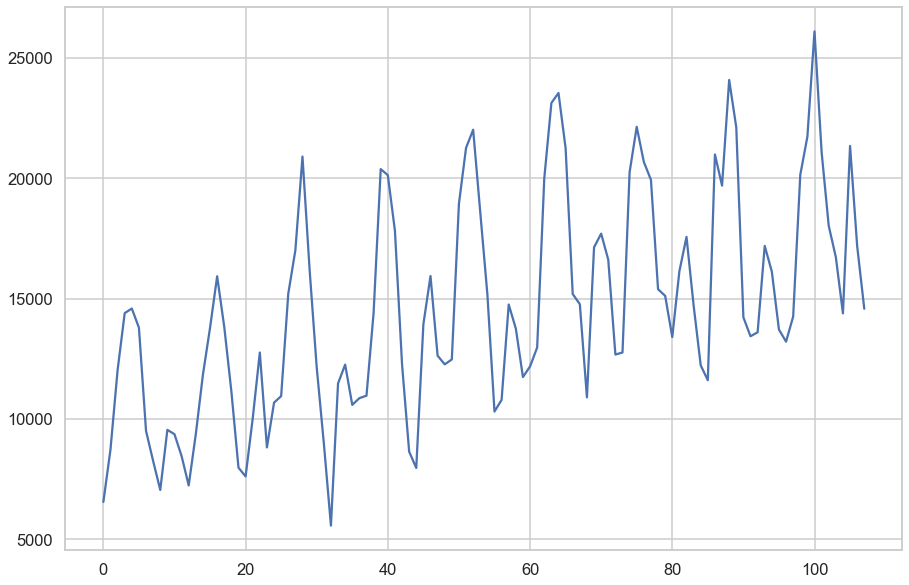

In [263]:
df1['Sales'].plot()

In [264]:
df2 = df1.copy()

In [265]:
df1['m'] = df1['Month'].dt.month
df1['y'] = df1['Month'].dt.year    
    

# Будуємо модель окремо для кожного місяця в роках і передбачаємо значення на місць поточного року, далі обєднуємо модуль для отримання прогнозу на 12 місяців з використанням лінійної регресії

In [266]:
train, test = df1[0:-12], df1[-12:]
out = list()
mod = LinearRegression()
for m in range(1,13):
    train1 = train[train['m'] == m]
    test1 = test[test['m']== m]
    
    mod.fit(train1[['y']], train1['Sales'])
    predictions = mod.predict(test1[['y']])
    test1['preds']=predictions
    
    out.append(test1)

In [267]:
test = pd.concat(out)
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=test['preds'])]))

In [268]:
R2_SCORE = r2_score(test['Sales'], test['preds'])
MAE = mean_absolute_error(test['Sales'], test['preds'])
print(f'R2Score = {np.round(R2_SCORE,3)}, MAE = {np.round(MAE,3)}')

R2Score = 0.765, MAE = 1588.708


In [269]:
results = {}
results['R2_SCORE, MAE for LinReg for month']=(np.round(R2_SCORE,3), np.round(MAE,3))


# Будуємо модель окремо для кожного місяця в роках і передбачаємо значення на місць поточного року, далі обєднуємо модуль для отримання прогнозу на 12 місяців з використанням рандом форест

In [270]:
train, test = df1[0:-12], df1[-12:]
out = list()
mod = RandomForestRegressor()
for m in range(1,13):
    train1 = train[train['m'] == m]
    test1 = test[test['m']== m]
    
    mod.fit(train1[['y']], train1['Sales'])
    predictions = mod.predict(test1[['y']])
    test1['preds']=predictions
    
    out.append(test1)
test = pd.concat(out) 
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=test['preds'])]))

In [271]:
R2_SCORE = r2_score(test['Sales'], test['preds'])
MAE = mean_absolute_error(test['Sales'], test['preds'])
print(f'R2Score = {np.round(R2_SCORE,3)}, MAE = {np.round(MAE,3)}')

R2Score = 0.653, MAE = 1735.967


In [272]:
results['R2_SCORE, MAE for RandomForest for month']=(np.round(R2_SCORE,3), np.round(MAE,3))

In [273]:
results

{'R2_SCORE, MAE for LinReg for month': (0.765, 1588.708),
 'R2_SCORE, MAE for RandomForest for month': (0.653, 1735.967)}

# Будуємо модель з targetEncoding з використанням лінійної регресії

In [274]:
size = len(df1)
test_size = 12
n_splits = 5
r2_list = list()
mae_list = list()
mod = LinearRegression()


for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df1[0:idx]
    test = df1[idx:idx+test_size]
    avg_month = train.groupby('m')['Sales'].mean()
    
    train = train.assign(avg_month = train['m'].map(avg_month))
    test = test.assign(avg_month = test['m'].map(avg_month))
    
    mod.fit(train[['avg_month']], train['Sales'])
    preds = mod.predict(test[['avg_month']])
    
    r2_list.append(r2_score(test['Sales'], preds))
    mae_list.append(mean_absolute_error(test['Sales'], preds))
print(f'R2Score = {np.round(np.mean(r2_list),3)}, MAE = {np.round(np.mean(mae_list),3)}')

R2Score = -0.109, MAE = 3631.953


In [275]:
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=preds)]))

In [276]:
results['R2_SCORE, MAE for LinReg for targetEncoding']=(np.round(np.mean(r2_list),3), np.round(np.mean(mae_list),3))

# Будуємо модель з targetEncoding з використанням рандом форест

In [277]:
size = len(df1)
test_size = 12
n_splits = 5
r2_list = list()
mae_list = list()
mod = RandomForestRegressor()


for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df1[0:idx]
    test = df1[idx:idx+test_size]
    avg_month = train.groupby('m')['Sales'].mean()
    
    train = train.assign(avg_month = train['m'].map(avg_month))
    test = test.assign(avg_month = test['m'].map(avg_month))
    
    mod.fit(train[['avg_month']], train['Sales'])
    preds = mod.predict(test[['avg_month']])
    
    r2_list.append(r2_score(test['Sales'], preds))
    mae_list.append(mean_absolute_error(test['Sales'], preds))
print(f'R2Score = {np.round(np.mean(r2_list),3)}, MAE = {np.round(np.mean(mae_list),3)}')

R2Score = -0.117, MAE = 3641.023


In [278]:
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=preds)]))

In [279]:
results['R2_SCORE, MAE for RandomForest for targetEncoding']=(np.round(np.mean(r2_list),3), np.round(np.mean(mae_list),3))

# Будуємо модель з Lags з використанням LinReg

In [280]:
for i in range(1,15):
    df2[f'i-{i}'] = df2['Sales'].shift(i)


In [281]:
df2.fillna(df2.mean(),inplace=True)

In [282]:
features = ['i-'+str(i) for i in range(1,15)]

size = len(df2)
test_size = 12
n_splits = 5
r2_list = list()
mae_list = list()
mod = LinearRegression()

for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df2[0:idx]
    test = df2[idx:idx+test_size]
    predictions = list()
    error = list()
    
    for i in range((test_size)):
        step = test[i:i+1]
    
        mod.fit(train[features],train['Sales'])
        preds = mod.predict(step[features])
        predictions.append(preds[0])
        error.append(mean_absolute_error(step['Sales'],preds))
    
        train = pd.concat([train,step])

In [283]:
r2 = r2_score(test['Sales'],predictions)
print(f'R2Score = {np.round(r2,3)}, MAE = {np.round(np.mean(error),3)}')

R2Score = 0.752, MAE = 1537.048


In [284]:
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=predictions)]))

In [285]:
results['R2_SCORE, MAE for LinReg with Lags']=(np.round(r2,3),np.round(np.mean(error),3))

# Будуємо модель з Lags з використанням RandomForest

In [286]:
size = len(df2)
test_size = 12
n_splits = 5
mod = RandomForestRegressor()

for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df2[0:idx]
    test = df2[idx:idx+test_size]
    predictions = list()
    error = list()
    
    for i in range((test_size)):
        step = test[i:i+1]
    
        mod.fit(train[features],train['Sales'])
        preds = mod.predict(step[features])
        predictions.append(preds[0])
        error.append(mean_absolute_error(step['Sales'],preds))
    
        train = pd.concat([train,step])

In [287]:
r2 = r2_score(test['Sales'],predictions)
print(f'R2Score = {np.round(r2,3)}, MAE = {np.round(np.mean(error),3)}')

R2Score = 0.552, MAE = 1884.579


In [288]:
r2

0.5524994167076578

In [289]:
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=predictions)]))

In [290]:
results['R2_SCORE, MAE for RandomForest with Lags']=(np.round(r2,3),np.round(np.mean(error),3))

# Будуємо мікс модель з використанням лагів та навчання по місяцям

In [291]:
df3 = df1.copy()

In [292]:
df3['m'] = df3['Month'].dt.month
df3['y'] = df3['Month'].dt.year  

In [293]:
for i in range(1,15):
    df3[f'i-{i}'] = df3['Sales'].shift(i)

In [294]:
df3.fillna(df3.mean(),inplace=True)

In [295]:
features = ['i-'+str(i) for i in range(1,15)] 
features.append('y')
features.append('m')

In [296]:

out = list()

size = len(df2)
test_size = 12
n_splits = 5
out = list()
test_crossval = list()
mod = LinearRegression()


for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df3[0:idx]
    test = df3[idx:idx+test_size]
    test_crossval.append(test['Sales'])

        
    
    for m in range(1,13):
        train1 = train[train['m'] == m]
        test1 = test[test['m']== m]
    
        mod.fit(train1[['y']], train1['Sales'])
        predictions = mod.predict(test1[['y']])
        test1['preds']=predictions
        out.append(float(predictions))
    

        

In [297]:
test_cross_valid_values = np.array(test_crossval).reshape(12,5)
predictions_cross_val = np.array(np.round(out,3)).reshape(12,5)

In [298]:
mean_abs_error = np.mean(np.array([mean_absolute_error(test_cross_valid_values[:,i], predictions_cross_val[:,i]) for i in range(5)]))
r2_error = np.mean(np.array([r2_score(test_cross_valid_values[:,i], predictions_cross_val[:,i]) for i in range(5)]))

In [299]:
iplot(Figure(data=[Scatter(y=test['Sales']),
                  Scatter(y=np.mean(predictions_cross_val, axis=1))]))

In [300]:
print(f'R2Score = {np.round(r2_error,3)}, MAE = {np.round(mean_abs_error,3)}')

R2Score = 0.654, MAE = 1729.631


In [301]:
results['R2_SCORE, MAE for Mixed model LinReg']=(np.round(r2_error,3),np.round(mean_abs_error,3))

In [302]:
results

{'R2_SCORE, MAE for LinReg for month': (0.765, 1588.708),
 'R2_SCORE, MAE for RandomForest for month': (0.653, 1735.967),
 'R2_SCORE, MAE for LinReg for targetEncoding': (-0.109, 3631.953),
 'R2_SCORE, MAE for RandomForest for targetEncoding': (-0.117, 3641.023),
 'R2_SCORE, MAE for LinReg with Lags': (0.752, 1537.048),
 'R2_SCORE, MAE for RandomForest with Lags': (0.552, 1884.579),
 'R2_SCORE, MAE for Mixed model LinReg': (0.654, 1729.631)}

Временной ряд №2
---
Колонки
* Period - дата 
* Revenue - Доход (таргет)
* Sales_quantity - количество проданных товаров. Можно использовать как признак, но только не в текущий момент времени, так как мы не знаем, сколько мы товаров продадим на момент прогноза
* Average_cost - средняя цена товара (Revenue / Sales_quantity) 

In [700]:
df4 = pd.read_csv('../datatest/month_value.csv')

In [701]:
df4.head()

,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,1.601007e+07,12729.0,1257.763541
1,01.02.2015,1.580759e+07,11636.0,1358.507000
2,01.03.2015,2.204715e+07,15922.0,1384.697024
3,01.04.2015,1.881458e+07,15227.0,1235.606705
4,01.05.2015,1.402148e+07,8620.0,1626.621765


In [702]:
# correlations
df4.corr()

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.887570,0.358278
Sales_quantity,0.887570,1.000000,-0.093599
Average_cost,0.358278,-0.093599,1.000000


In [703]:
df4['Period'] = pd.date_range(start='01-2015', end='04-2020', freq='MS')

In [704]:
df4['month'] = df4['Period'].dt.month
df4['year'] = df4['Period'].dt.year  

In [705]:
df4.set_index('Period', inplace=True)

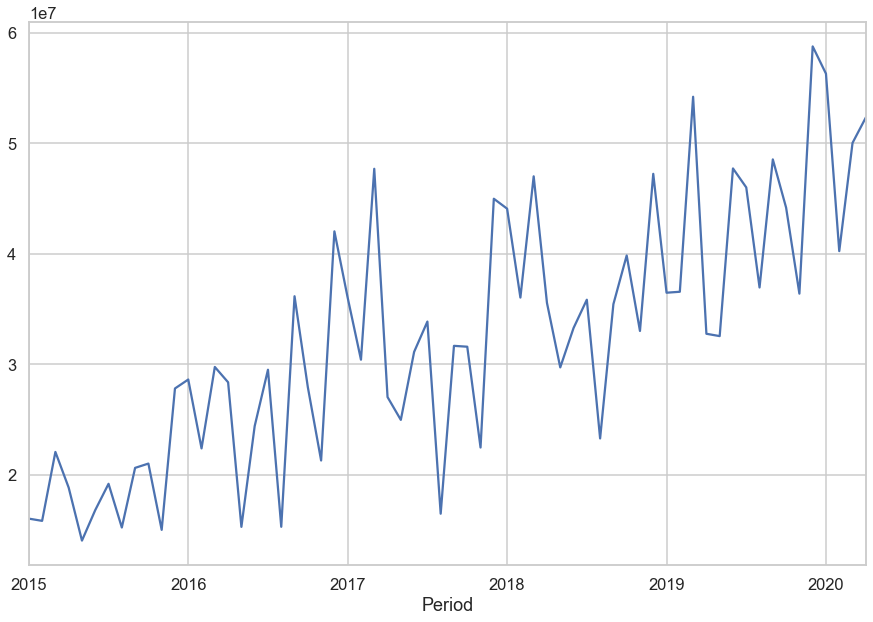

In [706]:
df4['Revenue'].plot()
plt.show()

In [707]:
df5 = df4.copy()
df6 = df4.copy()

Задание 
---
Используя предыдущие приемы, а так же добавив еще признаки из датасета, так же построить прогноз на 3 месяца и на год вперед

# На 3 місяці вперед

In [727]:
def plot_results(data, model, x, features, target, test_size):
    train, test = data[0:-test_size], data[-test_size:]
    model.fit(train[features], train[target])
    predictions = model.predict(test[features])
    
    trace1 = Scatter(x=train[x],
                    y=train[target],
                    name='Train set')
    trace2 = Scatter(x=test[x], 
                    y = test[target],
                    name = 'Test set')
    
    trace3 = Scatter(x=test[x],
                    y=predictions,
                    name = 'Predictions')
    
    iplot(Figure(data=[trace1, trace2, trace3]))
    
    

In [708]:
features = [ 'Average_cost', 'year', 'month']
mod = RandomForestRegressor()

train, test = df4[0:-3], df4[-3:]
mod.fit(train[features], train['Revenue'])
preds = mod.predict(test[features])
test = test.assign(preds=preds)

In [709]:
iplot(Figure(data=[Scatter(y=test['preds'], name='Predictions'),
                  Scatter(y=test['Revenue'], name='Original')]))

In [710]:
r2 = r2_score(test['Revenue'], test['preds'])
mae = mean_absolute_error(test['Revenue'], test['preds'])
print(f'R2 score = {r2}, MAE = {mae}')

R2 score = -0.5596565486311609, MAE = 5834952.083182623


In [713]:
features =  ['avg_month', 'avr_year', 'avr_sales_month', 'avr_sales_year',  'Average_cost', 'Sales_quantity']

In [714]:
size = len(df5)
test_size = 3
n_splits = 5
r2_list = list()
mae_list = list()
mod = RandomForestRegressor()


for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df5[0:idx]
    test = df5[idx:idx+test_size]
    
    avg_month = train.groupby('month')['Revenue'].mean()
    avr_sales_month = train.groupby('month')['Sales_quantity'].mean()
    avr_year = train.groupby('year')['Revenue'].mean()
    avr_sales_year = train.groupby('year')['Sales_quantity'].mean()
        
    
    train = train.assign(avg_month = train['month'].map(avg_month))
    train = train.assign(avr_sales_month = train['month'].map(avr_sales_month))
    train = train.assign(avr_year = train['year'].map(avr_year))
    train = train.assign(avr_sales_year = train['year'].map(avr_sales_year))
    train.dropna(inplace=True)
    
    test = test.assign(avg_month = test['month'].map(avg_month))
    test = test.assign(avr_sales_month = test['month'].map(avr_sales_month))
    test = test.assign(avr_year = test['year'].map(avr_year))
    test = test.assign(avr_sales_year = test['year'].map(avr_sales_year))
    test.dropna(inplace=True)
    
    
    
    mod.fit(train[features], train['Revenue'])
    preds = mod.predict(test[features])
    
    r2_list.append(r2_score(test['Revenue'], preds))
    mae_list.append(mean_absolute_error(test['Revenue'], preds))
print(np.mean(r2_list))
print(np.mean(mae_list))   
    

0.23564837315949885
4498169.608738325


In [715]:
df5 = pd.concat([train,test])

In [716]:
df5.reset_index(inplace=True)

In [717]:
plot_results(df5, mod, 'Period', features, target='Revenue', test_size=3)

# На рік вперед

In [718]:
features = [ 'Average_cost', 'Sales_quantity']
mod = RandomForestRegressor()

train, test = df6[0:-12], df6[-12:]
mod.fit(train[features], train['Revenue'])
preds = mod.predict(test[features])
test = test.assign(preds=preds)

In [719]:
iplot(Figure(data=[Scatter(y=test['preds'], name='Predictions'),
                  Scatter(y=test['Revenue'], name='Original')]))

In [720]:
r2 = r2_score(test['Revenue'], test['preds'])
mae = mean_absolute_error(test['Revenue'], test['preds'])
print(f'R2 score = {r2}, MAE = {mae}')

R2 score = 0.4195432803338053, MAE = 4859497.9324256405


In [721]:
len(df6)

64

In [722]:
features =  ['avg_month','avr_year','avr_sales_month', 'avr_sales_year','Average_cost','Sales_quantity']

In [723]:
size = len(df6)
test_size = 12
n_splits = 3
r2_list = list()
mae_list = list()
mod = RandomForestRegressor()


for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = df6[0:idx]
    test = df6[idx:idx+test_size]
    
    avg_month = train.groupby('month')['Revenue'].mean()
    avr_sales_month = train.groupby('month')['Sales_quantity'].mean()
    avr_year = train.groupby('year')['Revenue'].mean()
    avr_sales_year = train.groupby('year')['Sales_quantity'].mean()
        
    
    train = train.assign(avg_month = train['month'].map(avg_month))
    train = train.assign(avr_sales_month = train['month'].map(avr_sales_month))
    train = train.assign(avr_year = train['year'].map(avr_year))
    train = train.assign(avr_sales_year = train['year'].map(avr_sales_year))
    train.dropna(inplace=True)
    
    test = test.assign(avg_month = test['month'].map(avg_month))
    test = test.assign(avr_sales_month = test['month'].map(avr_sales_month))
    test = test.assign(avr_year = test['year'].map(avr_year))
    test = test.assign(avr_sales_year = test['year'].map(avr_sales_year))
    test.dropna(inplace=True)
    
    
    
    mod.fit(train[features], train['Revenue'])
    preds = mod.predict(test[features])
    
    r2_list.append(r2_score(test['Revenue'], preds))
    mae_list.append(mean_absolute_error(test['Revenue'], preds))
print(np.mean(r2_list))
print(np.mean(mae_list))   

0.5618127906731715
3840823.136806926


In [724]:
df6 = pd.concat([train,test])

In [725]:
df6.reset_index(inplace=True)

In [726]:
plot_results(df6, mod, 'Period', features, target='Revenue', test_size=12)